In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
  # Install dependencies
  ! pip install --upgrade pip
  ! pip install czitools
  ! pip install ipyfilechooser

In [9]:
# import the required libraries
from czitools.metadata_tools import czi_metadata as czimd
from czitools.read_tools import read_tools as czird
from czitools.utils import misc
from ipyfilechooser import FileChooser
from IPython.display import display, HTML
import os
import dask.array as da
import requests
import glob
import ipywidgets as widgets

if not IN_COLAB:
    import napari
    from napari.utils.colormaps import Colormap


In [4]:
# try to find the folder with data and download otherwise from GitHub.

# Folder containing the input data
if IN_COLAB:
    INPUT_FOLDER = 'data/'
if not IN_COLAB:
    INPUT_FOLDER = '../../data/'

# Path to the data on GitHub
GITHUB_IMAGES_PATH = "https://raw.githubusercontent.com/sebi06/czitools/main/data.zip"

# Download data
if not (os.path.isdir(INPUT_FOLDER)):
    compressed_data = './data.zip'
    if not os.path.isfile(compressed_data):
        import io
        response = requests.get(GITHUB_IMAGES_PATH, stream=True)
        compressed_data = io.BytesIO(response.content)

    import zipfile
    with zipfile.ZipFile(compressed_data, 'r') as zip_accessor:
        zip_accessor.extractall('./')

In [5]:
if not IN_COLAB:
    # choose local file
    fc = FileChooser()
    fc.default_path = INPUT_FOLDER
    fc.filter_pattern = '*.czi'
    display(fc)

elif IN_COLAB:
    # list files inside the folder on gdrive
    czifiles = glob.glob(os.path.join(INPUT_FOLDER, "*.czi"))
    wd = widgets.Select(
        options=czifiles,
        description='CZI Files:',
        layout={'width': 'max-content'}
    )
    display(wd)

FileChooser(path='F:\Github\czitools\data', filename='', title='', show_hidden=False, select_desc='Select', ch…

In [6]:
if not IN_COLAB:
    filepath = fc.selected
elif IN_COLAB:
    filepath = wd.value

print(f"Selected File: {filepath}")

Selected File: F:\Github\czitools\data\CellDivision_T10_Z15_CH2_DCV_small.czi


In [7]:
# get the complete metadata at once as one big class
mdata = czimd.CziMetadata(filepath)

# get the CZI metadata dictionary directly from filename
mdict = czimd.create_md_dict_red(mdata, sort=False, remove_none=True)

# convert metadata dictionary to a pandas dataframe
mdframe = misc.md2dataframe(mdict)

# create a ipywdiget to show the dataframe with the metadata
wd = widgets.Output(layout={"scrollY": "auto", "height": "300px"})

with wd:
    display(HTML(mdframe.to_html()))
display(widgets.VBox(children=[wd]))

Reading sublocks planes: 0 2Dplanes [00:00, ? 2Dplanes/s]

In [8]:
# return array with dimension order STCZYX(A)
array6d, mdata= czird.read_6darray(filepath, use_dask=False, chunk_zyx=False, use_xarray=True)

# print the shape of the array etc.
print(f"Shape: {array6d.shape}")
print(f"Dimensions: {array6d.dims}")

for k, v in array6d.attrs.items():
    print(f"{k} :  {v}")

# show dask array structure
if isinstance(array6d, da.Array):
    print(array6d)
else:
    print("Shape:", array6d.shape, "dtype:", array6d.dtype)


Reading sublocks planes: 0 2Dplanes [00:00, ? 2Dplanes/s]

Reading 2D planes: 0 2Dplanes [00:00, ? 2Dplanes/s]

Shape: (1, 10, 2, 15, 256, 256)
Dimensions: ('S', 'T', 'C', 'Z', 'Y', 'X')
description :  6D image data from CZI file
source :  F:\Github\czitools\data\CellDivision_T10_Z15_CH2_DCV_small.czi
axes :  STCZYX
Shape: (1, 10, 2, 15, 256, 256) dtype: uint16


In [10]:
if not IN_COLAB:

    # show in napari (requires napari to be installed!)
    viewer = napari.Viewer()

    # loop over all channels
    for ch in range(0, array6d.sizes["C"]):

        # extract channel subarray
        sub_array = array6d.sel(C=ch)

        # get the scaling factors for that channel and adapt Z-axis scaling
        scalefactors = [1.0] * len(sub_array.shape)
        scalefactors[sub_array.get_axis_num("Z")] = mdata.scale.ratio["zx_sf"] * 1.00001

        # remove the last scaling factor in case of an RGB image
        if "A" in sub_array.dims:
            # remove the A axis from the scaling factors
            scalefactors.pop(sub_array.get_axis_num("A"))

        # get colors and channel name
        chname = mdata.channelinfo.names[ch]

        # inside the CZI metadata_tools colors are defined as ARGB hexstring
        rgb = "#" + mdata.channelinfo.colors[ch][3:]
        ncmap = Colormap(["#000000", rgb], name="cm_" + chname)

        # add the channel to the viewer
        viewer.add_image(
            sub_array,
            name=chname,
            colormap=ncmap,
            blending="additive",
            scale=scalefactors,
            gamma=0.85,
        )

        # set the axis labels based on the dimensions
        viewer.dims.axis_labels = sub_array.dims

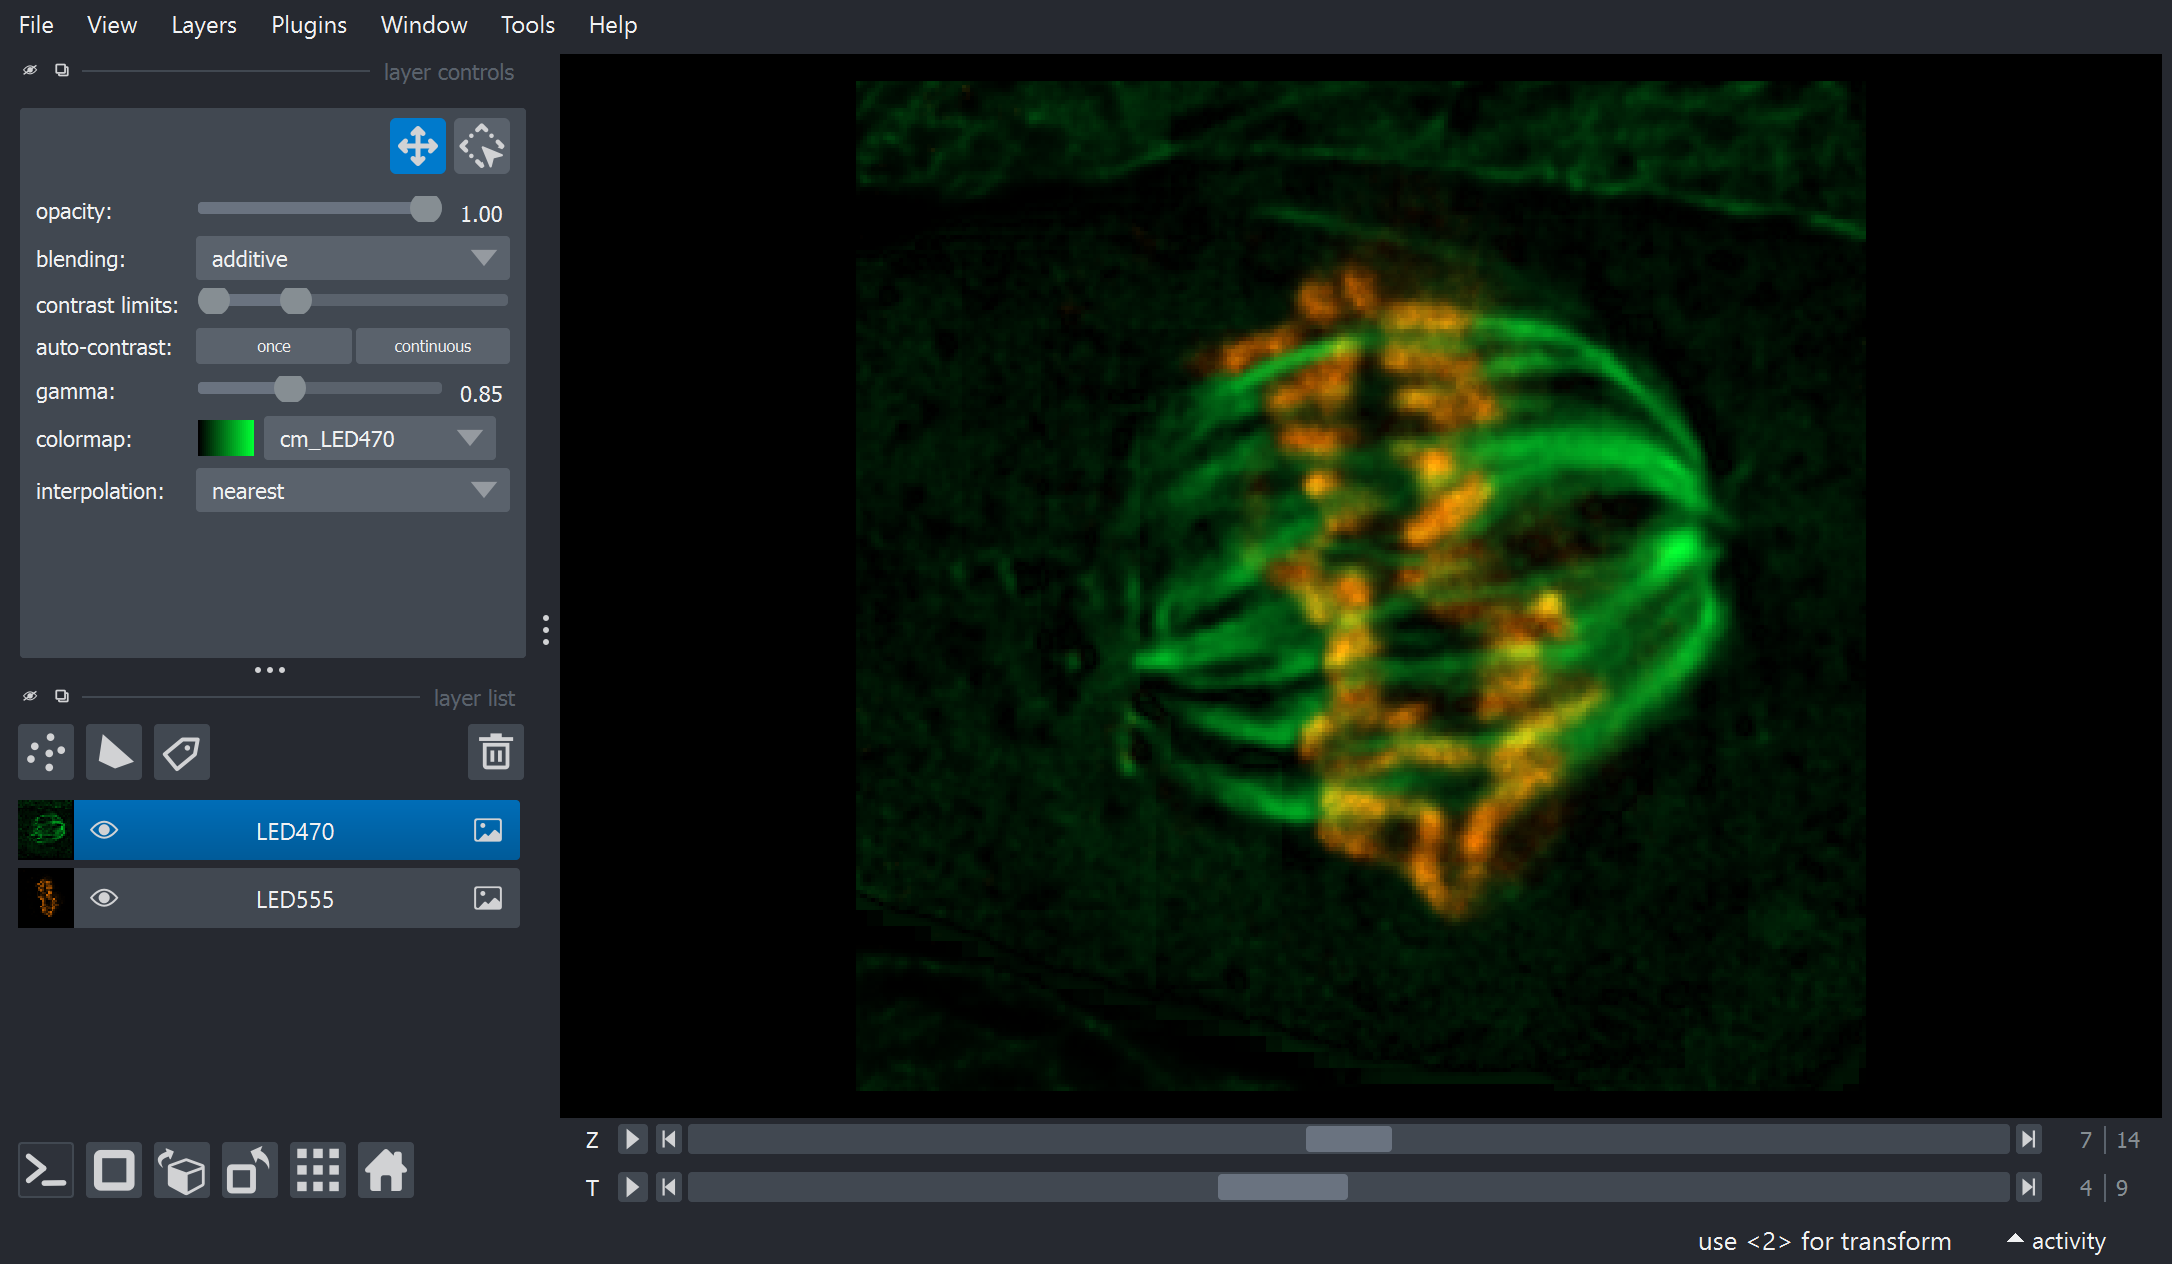

In [11]:
napari.utils.nbscreenshot(viewer)